In [1]:
'''
Patrick Ballou
ID: 801130521
ECGR 4106
Homework 5
Problem 2
'''

'\nPatrick Ballou\nID: 801130521\nECGR 4106\nHomework 5\nProblem 2\n'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import cuda
import requests
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import time

In [3]:
#check if GPU is available and set the device accordingly
#device = 'torch.device("cuda:0" if torch.cuda.is_available() else "cpu")'
device = 'cuda'
print("Using GPU: ", cuda.get_device_name())

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Using GPU:  NVIDIA L4
Fri Apr 26 05:27:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   33C    P8              12W /  72W |      4MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+---

In [4]:
# Pred dataset for training
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text  # This is the entire text data

chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = [char_to_int[ch] for ch in text]

In [5]:
class CharDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]

def prepare_dataset(sequence_length):
    sequences = []
    targets = []
    for i in range(0, len(encoded_text) - sequence_length):
        seq = encoded_text[i:i+sequence_length]
        target = encoded_text[i+sequence_length]
        sequences.append(seq)
        targets.append(target)

    # Convert lists to PyTorch tensors
    sequences = torch.tensor(sequences, dtype=torch.long)
    targets = torch.tensor(targets, dtype=torch.long)

    # Instantiate the dataset
    dataset = CharDataset(sequences, targets)

    # Create data loaders
    batch_size = 64
    train_size = int(len(dataset) * 0.8)
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

    return train_loader, test_loader

# Defining the Transformer model
class CharTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, nhead):
        super(CharTransformer, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded)
        output = self.fc(transformer_output[:, -1, :])  # Get the output of the last Transformer block
        return output

In [6]:
def training_loop(model, criterion, optimizer, epochs, train_loader, test_loader, max_length):

    train_history = []
    val_history = []
    init_time = time.time()
    print(f"{max_length} sequence transformer results:")

    # Training the model
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            running_loss += loss.item()
            optimizer.step()

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        train_history.append(running_loss / len(train_loader))
        val_history.append(correct / total * 100)

        print(f'Epoch {epoch+1}, Loss: {train_history[-1]}, Validation Accuracy: {val_history[-1]}')

    print(f"Training time: {(time.time() - init_time)/60} minutes")
    save_path = f'../../Models/hw5_2_{max_length}.pth'
    #torch.save(model.state_dict(), save_path)

    return train_history, val_history

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str, max_length):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([char_to_ix[c] for c in initial_str[-max_length:]], dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[int(predicted_index)]

def next_char_test(model, max_length):
    test_str = "This is a simple example to demonstrate how to predict the next char"
    predicted_char = predict_next_char(model, char_to_int, int_to_char, test_str, max_length)
    print(f"Predicted next character: '{predicted_char}'")

# **Problem 2A:** 20, 30, 50 sequence lengths

In [7]:
# Hyperparameters
hidden_size = 256
num_layers = 3
nhead = 2

max_lengths = [20, 30, 50]
learning_rate = .0005
epochs = 10

In [8]:
train_histories = []
val_histories = []
models = []

for window_size in max_lengths:
    model = CharTransformer(len(chars), hidden_size, len(chars), num_layers, nhead).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loader, test_loader = prepare_dataset(window_size)

    train_history, val_history = training_loop(model, criterion, optimizer, epochs, train_loader, test_loader, window_size)
    train_histories.append(train_history)
    val_histories.append(val_history)
    print("\n")

    next_char_test(model, window_size)
    print("\n\n") if window_size != 50 else None
    models.append(model)

20 sequence transformer results:
Epoch 1, Loss: 2.3781242570840826, Validation Accuracy: 32.22817438081363
Epoch 2, Loss: 2.279810735718178, Validation Accuracy: 33.539840860697076
Epoch 3, Loss: 2.241520992432059, Validation Accuracy: 34.3328476969629
Epoch 4, Loss: 2.2162290881390225, Validation Accuracy: 34.64754006500056
Epoch 5, Loss: 2.1989653752505554, Validation Accuracy: 35.11061302252605
Epoch 6, Loss: 2.18619710241612, Validation Accuracy: 35.27916619970862
Epoch 7, Loss: 2.1737852297989937, Validation Accuracy: 35.47102992267175
Epoch 8, Loss: 2.1642856603030247, Validation Accuracy: 35.80903283648997
Epoch 9, Loss: 2.156897004832413, Validation Accuracy: 35.6830662333296
Epoch 10, Loss: 2.14928344218912, Validation Accuracy: 35.872688557659984
Training time: 20.495648515224456 minutes


Predicted next character: 'e'



30 sequence transformer results:
Epoch 1, Loss: 2.4477557629498605, Validation Accuracy: 29.327170926109392
Epoch 2, Loss: 2.4148842569557893, Validation Ac

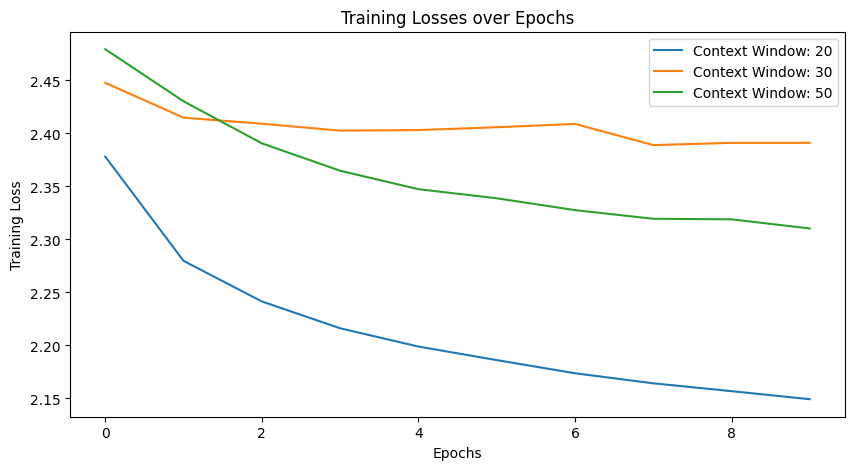

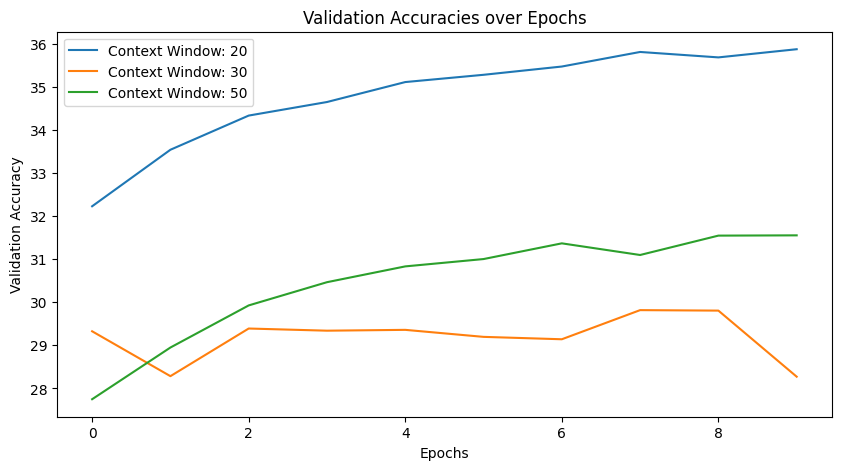

In [9]:
# Plotting training losses
plt.figure(figsize=(10, 5))
for i, max_length in enumerate(max_lengths):
    plt.plot(train_histories[i], label=f"Context Window: {max_length}")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Losses over Epochs")
plt.legend()
plt.show()

# Plotting validation accuracies
plt.figure(figsize=(10, 5))
for i, max_length in enumerate(max_lengths):
    plt.plot(val_histories[i], label=f"Context Window: {max_length}")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracies over Epochs")
plt.legend()
plt.show()

# **Problem 2B:** Adjusting hyperparameters

In [10]:
# Hyperparameters
hidden_size = 256
num_layers = 4
nhead = 4

max_lengths = [20, 30, 50]
learning_rate = .0001
epochs = 15

In [11]:
train_histories = []
val_histories = []
models_b = []

for window_size in max_lengths:
    model = CharTransformer(len(chars), hidden_size, len(chars), num_layers, nhead).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loader, test_loader = prepare_dataset(window_size)

    train_history, val_history = training_loop(model, criterion, optimizer, epochs, train_loader, test_loader, window_size)
    train_histories.append(train_history)
    val_histories.append(val_history)
    print("\n")

    next_char_test(model, window_size)
    print("\n\n") if window_size != 50 else None
    models_b.append(model)

20 sequence transformer results:
Epoch 1, Loss: 2.328511470831134, Validation Accuracy: 34.16832903731929
Epoch 2, Loss: 2.2072384393959865, Validation Accuracy: 35.147820239829656
Epoch 3, Loss: 2.168260598186098, Validation Accuracy: 35.704583660203966
Epoch 4, Loss: 2.14332148995947, Validation Accuracy: 35.966379020508796
Epoch 5, Loss: 2.1239149742657233, Validation Accuracy: 36.43572789420598
Epoch 6, Loss: 2.1068844257960198, Validation Accuracy: 36.61190182673988
Epoch 7, Loss: 2.091532752074941, Validation Accuracy: 36.78000672419589
Epoch 8, Loss: 2.0778255151777247, Validation Accuracy: 36.94855990137846
Epoch 9, Loss: 2.064630270619855, Validation Accuracy: 37.07273338563263
Epoch 10, Loss: 2.0519855890743943, Validation Accuracy: 37.278045500392246
Epoch 11, Loss: 2.0401073334284274, Validation Accuracy: 37.0588367141096
Epoch 12, Loss: 2.0277804503830383, Validation Accuracy: 37.38787403339684
Epoch 13, Loss: 2.0159855133439124, Validation Accuracy: 37.34932197691359
Epoc

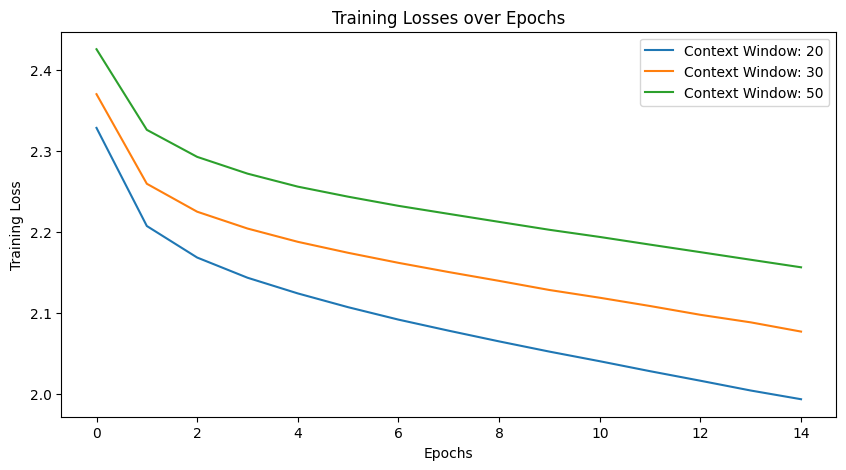

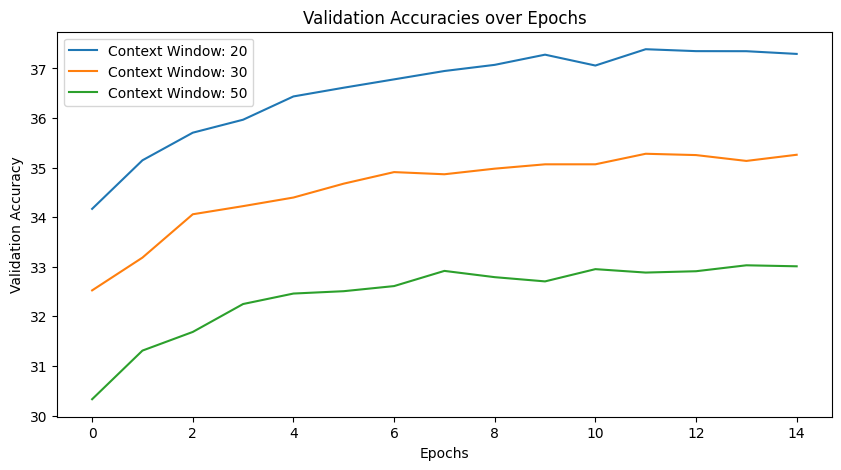

In [12]:
# Plotting training losses
plt.figure(figsize=(10, 5))
for i, max_length in enumerate(max_lengths):
    plt.plot(train_histories[i], label=f"Context Window: {max_length}")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Losses over Epochs")
plt.legend()
plt.show()

# Plotting validation accuracies
plt.figure(figsize=(10, 5))
for i, max_length in enumerate(max_lengths):
    plt.plot(val_histories[i], label=f"Context Window: {max_length}")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracies over Epochs")
plt.legend()
plt.show()